# Bin Raw Data

select subset / remove outliers before binning


### Package Imports

In [2]:
# need to add parent directory to sys.path...
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from IPython.display import display
from PyOptimalInterpolation import get_data_path
from PyOptimalInterpolation.dataloader import DataLoader
from PyOptimalInterpolation.utils import config_func, stats_on_vals, WGS84toEASE2_New, EASE2toWGS84_New
from PyOptimalInterpolation.plot_utils import plot_pcolormesh, plot_hist

pd.set_option('display.max_columns', 200)

# Parameters

In [3]:
# ---
# input (raw) data params
# ---

input_file = get_data_path("example", "ABC.h5")

table = "data"
val_col = "obs"
lon_col = "lon"
lat_col = "lat"

# ---
# binning params
# ---

output_file = get_data_path("example", "ABC_binned.nc")

bin_where = [
    {"col": val_col, "comp": ">=", "val": -2.0},
    {"col": val_col, "comp": "<=", "val": 2.0}
]

# columns to bin by - will become dimensions in xarray
bin_by_col = ["source", "date"]
# x,y columns
x_col, y_col = 'x', 'y'
# grid resolution (in meters)
grid_res = 50 * 1000
# x,y ranges
x_range=[-4500000.0, 4500000.0]
y_range=[-4500000.0, 4500000.0]

# --
# plot params
# --

scatter_plot_size = 2


# Read Data

In [4]:
print("reading from hdf5 files")
# read by specifying file path
df = DataLoader.read_hdf(table=table, path=input_file)

print("head of data:")
print(df.head(3))


reading from hdf5 files
head of data:
           lon        lat            datetime source      obs
420 -61.821182  65.594139 2020-02-10 00:22:20      A  0.22610
421 -61.847626  65.620234 2020-02-10 00:22:23      A  0.21440
422 -61.851806  65.624354 2020-02-10 00:22:24      A  0.09765


# Stats on Data

In [5]:
print("*" * 20)
print("summary / stats table on metric (use for trimming)")

vals = df[val_col].values
stats_df = stats_on_vals(vals=vals, name=val_col,
                         qs=[0.01, 0.05] + np.arange(0.1, 1.0, 0.1).tolist() + [0.95, 0.99])

# print(stats_df)
display(stats_df)

********************
summary / stats table on metric (use for trimming)


,obs
measure,NaN
size,169575.000000
num_not_nan,169575.000000
num_inf,0.000000
min,-126.251043
mean,2.331068
max,1349.194600
std,30.829791
skew,20.702468
kurtosis,518.055374


# Select Subset of Data
(remove outliers)

In [6]:
bin_df = DataLoader.data_select(df, where=bin_where)

# Add Columns to Raw Data
needed for binning

In [7]:
bin_df['date'] = bin_df['datetime'].values.astype('datetime64[D]')
bin_df['x'], bin_df['y'] = WGS84toEASE2_New(bin_df['lon'], bin_df['lat'])


# Bin Data

In [8]:
# get a Dataset of binned data
ds_bin = DataLoader.bin_data_by(df=bin_df,
                                by_cols=bin_by_col,
                                x_col=x_col,
                                y_col=y_col,
                                val_col=val_col,
                                grid_res=grid_res,
                                x_range=x_range,
                                y_range=y_range)

# add lon,lat grid values to coords
x_grid, y_grid = np.meshgrid(ds_bin.coords['x'], ds_bin.coords['y'])
lon_grid, lat_grid = EASE2toWGS84_New(x_grid, y_grid)

ds_bin = ds_bin.assign_coords({"lon": (['y', 'x'], lon_grid),
                               "lat": (['y', 'x'], lat_grid)})



'bin_data_by': 0.356 seconds


# Store Binned Data to (netCDF) File

In [9]:
# write to file - mode = 'w' will overwrite file
DataLoader.write_to_netcdf(ds=ds_bin, path=output_file, mode="w")

# Review Binned Data

In [10]:
# all binned values
bin_obs = ds_bin[val_col].data
# average over date, source
# TODO: this should be more systematic
ave_obs = np.nanmean(ds_bin[val_col].data, axis=(2,3))

#
bin_stats_df = stats_on_vals(vals=bin_obs, name=val_col,
                             qs=[0.01, 0.05] + np.arange(0.1, 1.0, 0.1).tolist() + [0.95, 0.99])

print(bin_stats_df)

                       obs
measure                NaN
size         972000.000000
num_not_nan    8731.000000
num_inf           0.000000
min              -1.953833
mean              0.255915
max               1.997700
std               0.365640
skew             -0.960525
kurtosis          7.063179
q0.01            -1.133780
q0.05            -0.325681
q0.10            -0.087728
q0.20             0.091975
q0.30             0.174400
q0.40             0.229310
q0.50             0.280062
q0.60             0.323350
q0.70             0.375667
q0.80             0.448783
q0.90             0.580000
q0.95             0.751738
q0.99             1.327078


/tmp/ipykernel_8916/1653922669.py:5: RuntimeWarning: Mean of empty slice
  ave_obs = np.nanmean(ds_bin[val_col].data, axis=(2,3))


# Plot Binned Data
 taking average of values per grid cell


/home/buddy/miniconda3/envs/PyOI/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


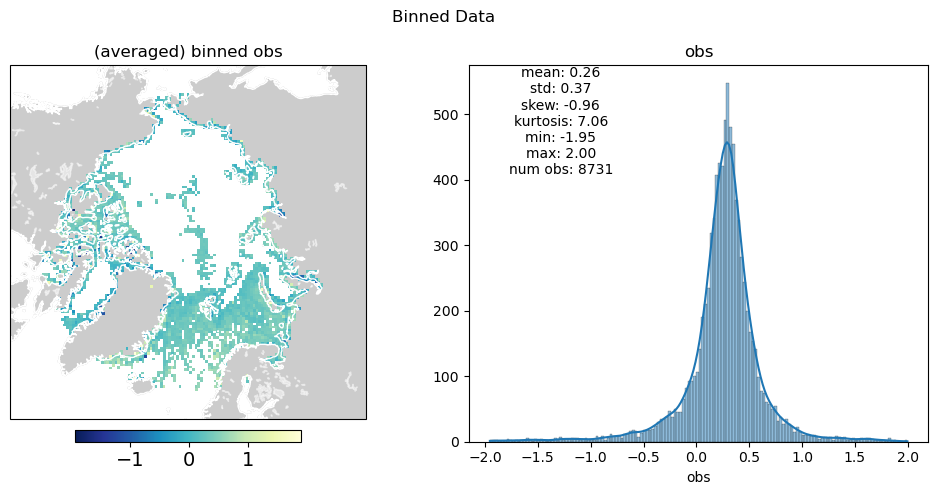

In [11]:

figsize = (10, 5)
fig = plt.figure(figsize=figsize)
fig.suptitle("Binned Data")

nrows, ncols = 1, 2

# first plot: heat map of observations
ax = fig.add_subplot(nrows, ncols, 1,
                     projection=ccrs.NorthPolarStereo())

plot_pcolormesh(ax=ax,
                lon=lon_grid,
                lat=lat_grid,
                plot_data=ave_obs,
                fig=fig,
                title=f"(averaged) binned {val_col}",
                # vmin=vmin,
                # vmax=vmax,
                cmap='YlGnBu_r',
                # cbar_label=cbar_labels[midx],
                scatter=False)

ax = fig.add_subplot(nrows, ncols, 2)

plot_hist(ax=ax,
          data=bin_obs[~np.isnan(bin_obs)],
          ylabel="",
          stats_values=['mean', 'std', 'skew', 'kurtosis', 'min', 'max', 'num obs'],
          title=val_col,
          xlabel=val_col,
          stats_loc=(0.2, 0.85))

plt.tight_layout()
plt.show()
